In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import os

zip_path = "/content/drive/My Drive/data/archive (2).zip"  # change name
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

data_dir = "/content/dataset"
os.listdir(data_dir)[:5]  # check folders


['lung_colon_image_set']

In [6]:
os.listdir("/content/dataset/lung_colon_image_set/lung_image_sets")


['lung_n', 'lung_scc', 'lung_aca']

Classes found: ['lung_n', 'lung_scc', 'lung_aca']


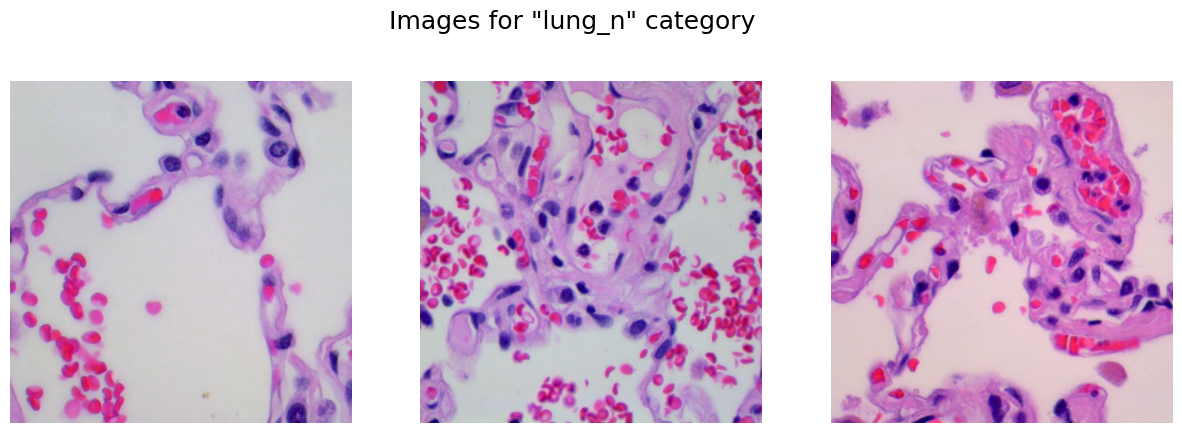

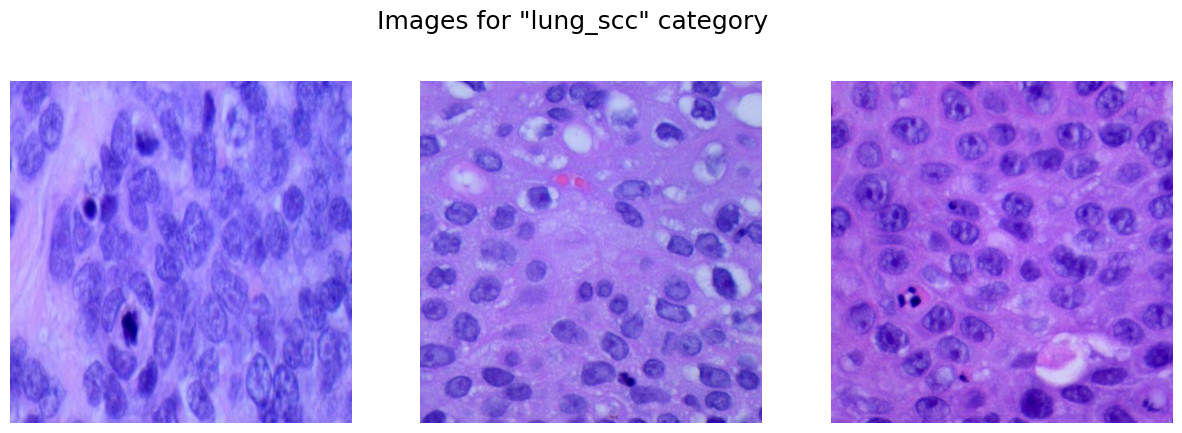

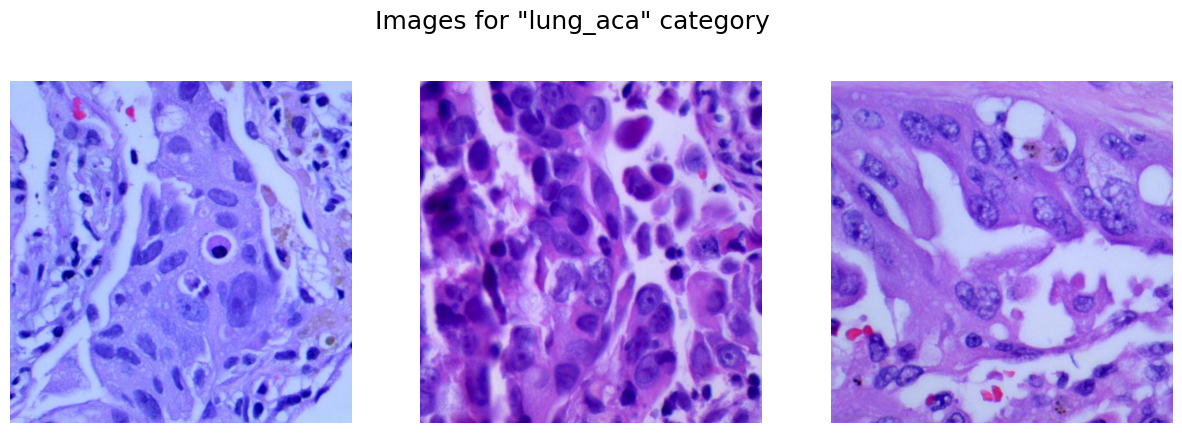

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define your correct base path (the folder containing class folders)
base_path = "/content/dataset/lung_colon_image_set/lung_image_sets"

# Get the class folder names
classes = os.listdir(base_path)
print("Classes found:", classes)

# Loop through each class
for cat in classes:
    image_dir = os.path.join(base_path, cat)

    # Get only image files (avoid subfolders)
    images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Skip if the folder has no images
    if len(images) == 0:
        print(f"No images found in {cat}, skipping...")
        continue

    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for "{cat}" category', fontsize=18)

    # Show 3 random images from this category
    for i in range(3):
        k = np.random.randint(0, len(images))
        img_path = os.path.join(image_dir, images[k])
        img = np.array(Image.open(img_path))
        ax[i].imshow(img)
        ax[i].axis('off')

    plt.show()


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ================== CONFIG ==================
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 20
SPLIT = 0.2  # Validation split ratio
path = "/content/dataset/lung_colon_image_set/lung_image_sets"
# ============================================

# Get class folders
classes = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
print("Detected classes:", classes)

X, Y = [], []

# Loop through each class folder
for i, cat in enumerate(classes):
    image_dir = os.path.join(path, cat)
    if not os.path.exists(image_dir):
        print(f"Folder not found: {image_dir}")
        continue

    # Include .jpg, .jpeg, .png images
    image_paths = (
        glob(os.path.join(image_dir, "*.jpg")) +
        glob(os.path.join(image_dir, "*.jpeg")) +
        glob(os.path.join(image_dir, "*.png"))
    )

    print(f"{cat}: {len(image_paths)} images found")

    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        Y.append(i)

# Convert to numpy arrays
X = np.array(X, dtype="float32") / 255.0  # Normalize 0–1
Y = np.array(Y)

print("Total images loaded:", X.shape[0])

# One-hot encode labels
Y_encoded = pd.get_dummies(Y).values
print("Encoded label shape:", Y_encoded.shape)

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y_encoded, test_size=SPLIT, random_state=2022, stratify=Y
)

print("Train shapes:", X_train.shape, Y_train.shape)
print("Val shapes:", X_val.shape, Y_val.shape)

# ================== DATA AUGMENTATION ==================
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Create augmented data generators
train_generator = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE, shuffle=False)

print(" Data augmentation successfully added!")
print(f"Train batches: {len(train_generator)} | Validation batches: {len(val_generator)}")


Detected classes: ['lung_n', 'lung_scc', 'lung_aca']
lung_n: 5000 images found
lung_scc: 5000 images found
lung_aca: 5000 images found
Total images loaded: 15000
Encoded label shape: (15000, 3)
Train shapes: (12000, 128, 128, 3) (12000, 3)
Val shapes: (3000, 128, 128, 3) (3000, 3)
✅ Data augmentation successfully added!
Train batches: 750 | Validation batches: 188


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
model = keras.models.Sequential([
    layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        activation='relu',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        padding='same'
    ),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Output layer for 3 classes
    layers.Dense(3, activation='softmax')
])

# Print model summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,518,467 (32.50 MB)

 Trainable params: 8,517,699 (32.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


es = EarlyStopping(
    monitor='val_accuracy',   # You can also use 'val_loss'
    patience=5,               # waits for 5 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

#  Reduce learning rate if validation loss doesn’t improve
lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1
)



In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose=1,
    callbacks=[es, lr]   # no custom callback now
)



Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8072 - loss: 0.4765 - val_accuracy: 0.7293 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8858 - loss: 0.2987 - val_accuracy: 0.8900 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9020 - loss: 0.2569 - val_accuracy: 0.5247 - val_loss: 2.0956 - learning_rate: 0.0010
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9049 - loss: 0.2432 - val_accuracy: 0.7143 - val_loss: 0.8486 - learning_rate: 0.0010
Epoch 5/20
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9223 - loss: 0.2067
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9223 - loss: 0.2067 - val_accuracy: 0.7873 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9314 - los

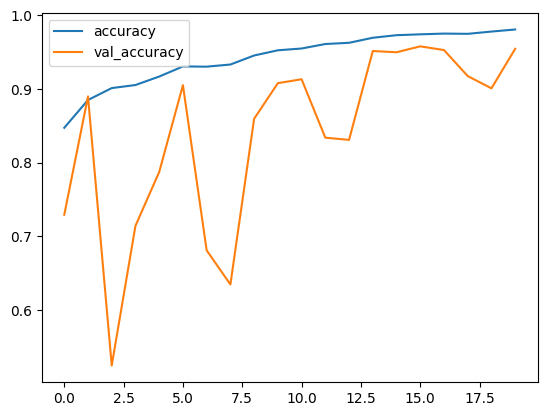

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [14]:
Y_pred = model.predict(X_val)



94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Make predictions (probabilities)
Y_pred = model.predict(X_val)

# Convert both predictions and true labels to class indices
if len(Y_pred.shape) > 1:
    Y_pred = np.argmax(Y_pred, axis=1)

if len(Y_val.shape) > 1:
    Y_val = np.argmax(Y_val, axis=1)

# Generate report
print(classification_report(Y_val, Y_pred, target_names=classes))


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

      lung_n       1.00      0.99      0.99      1000
    lung_scc       0.94      0.95      0.94      1000
    lung_aca       0.94      0.94      0.94      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [18]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

      lung_n       1.00      0.99      0.99      1000
    lung_scc       0.94      0.95      0.94      1000
    lung_aca       0.94      0.94      0.94      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


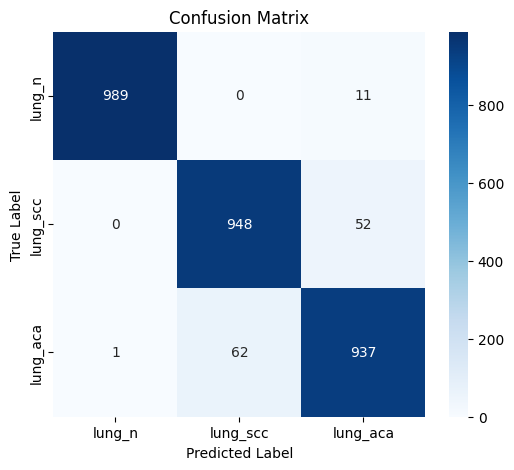

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#  Get model predictions
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

#  True labels (not one-hot encoded)
y_true = Y_val

#  Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

#  Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
